In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import numpy as np
import glob
from celluloid import Camera
import cv2
from pystackreg import StackReg
from skimage import io
from joblib import Parallel, delayed
from image_funcs import *
import mahotas as mh
import skimage
import peakutils
import scipy
from skimage.morphology import skeletonize
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.transform import probabilistic_hough_line, hough_line

In [2]:
directory = "/home/georgeosh/lvm_super_cluster/Dropbox (Cambridge University)/DATA_Bakshi_PaulssonLab/ND2_extracted/40x_Ph2_testData_TIFFs/40x_Ph2_Test_1_5_TIFFs/"
channel = "BF"
FOV = "xy09"
images = glob.glob(directory + "{}**{}.tif".format(FOV,channel)) 

In [3]:
ref = io.imread(images[0])
f, ax = plt.subplots(1,2, figsize=(40,20))
camera = Camera(f)
drift_corrected_images = Parallel(n_jobs=8)(delayed(correct_drift)(ref, io.imread(images[i])) for i in range(len(images)))
all_images = [drift_corrected_images[x][0] for x in range(len(drift_corrected_images))]
trans_matrices = [drift_corrected_images[x][1] for x in range(len(drift_corrected_images))]
for i in range(len(drift_corrected_images)):
    mov = io.imread(images[i])
    ax[0].imshow(mov)
    ax[0].axis("off")
    ax[0].set_title("Unregistered",fontsize=16)
    ax[1].imshow(all_images[i])
    ax[1].set_title("Registered",fontsize=16)
    ax[1].axis("off")
    plt.suptitle("Drift corrected vs uncorrected", fontsize=25)
    plt.tight_layout()
    camera.snap()
animation = camera.animate(interval = 200)
animation.save(
    'test_corrected.mp4', 
    writer = 'ffmpeg', 
    savefig_kwargs={
        'frameon': False,
        'pad_inches': 'tight'
    })

<ipython-input-3-102e1237d7f9>:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  animation.save(


In [12]:
def get_orientation(image):
    bin_image = image > threshold_minimum(image) * 1
    dilated = scipy.ndimage.morphology.binary_dilation(bin_image, iterations = 30)
    labeled, num_regions  = mh.label(dilated)
    sizes = mh.labeled.labeled_size(labeled)
    mh.labeled.labeled_size(labeled)
    too_small = np.where(sizes < sizes[1]-1)
    labeled = mh.labeled.remove_regions(labeled, too_small)
    skeleton = skeletonize(labeled)
    h, theta, d = hough_line(skeleton)
    origin = np.array((0, skeleton.shape[1]))
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    gradient = (y1-y0) /origin[1]

    return math.degrees(np.arctan(gradient))

get_orientation([0])

-3.1805546814635168e-15

In [56]:
all_images[0]

array([[569.        , 578.        , 567.99993896, ..., 609.        ,
        630.99993896, 636.        ],
       [575.        , 554.        , 507.        , ..., 608.        ,
        597.        , 679.        ],
       [543.        , 525.        , 508.        , ..., 645.        ,
        656.        , 691.        ],
       ...,
       [769.        , 879.        , 866.        , ..., 631.        ,
        698.        , 830.        ],
       [823.        , 803.        , 802.        , ..., 709.        ,
        757.        , 775.        ],
       [821.        , 837.        , 805.        , ..., 758.        ,
        710.        , 747.        ]])

In [58]:
top_half_images = []
bottom_half_images = []
for i in range(len(all_images)):
    top_half_images.append(get_img_half(all_images[i],"top"))
    bottom_half_images.append(get_img_half(all_images[i],"bottom"))

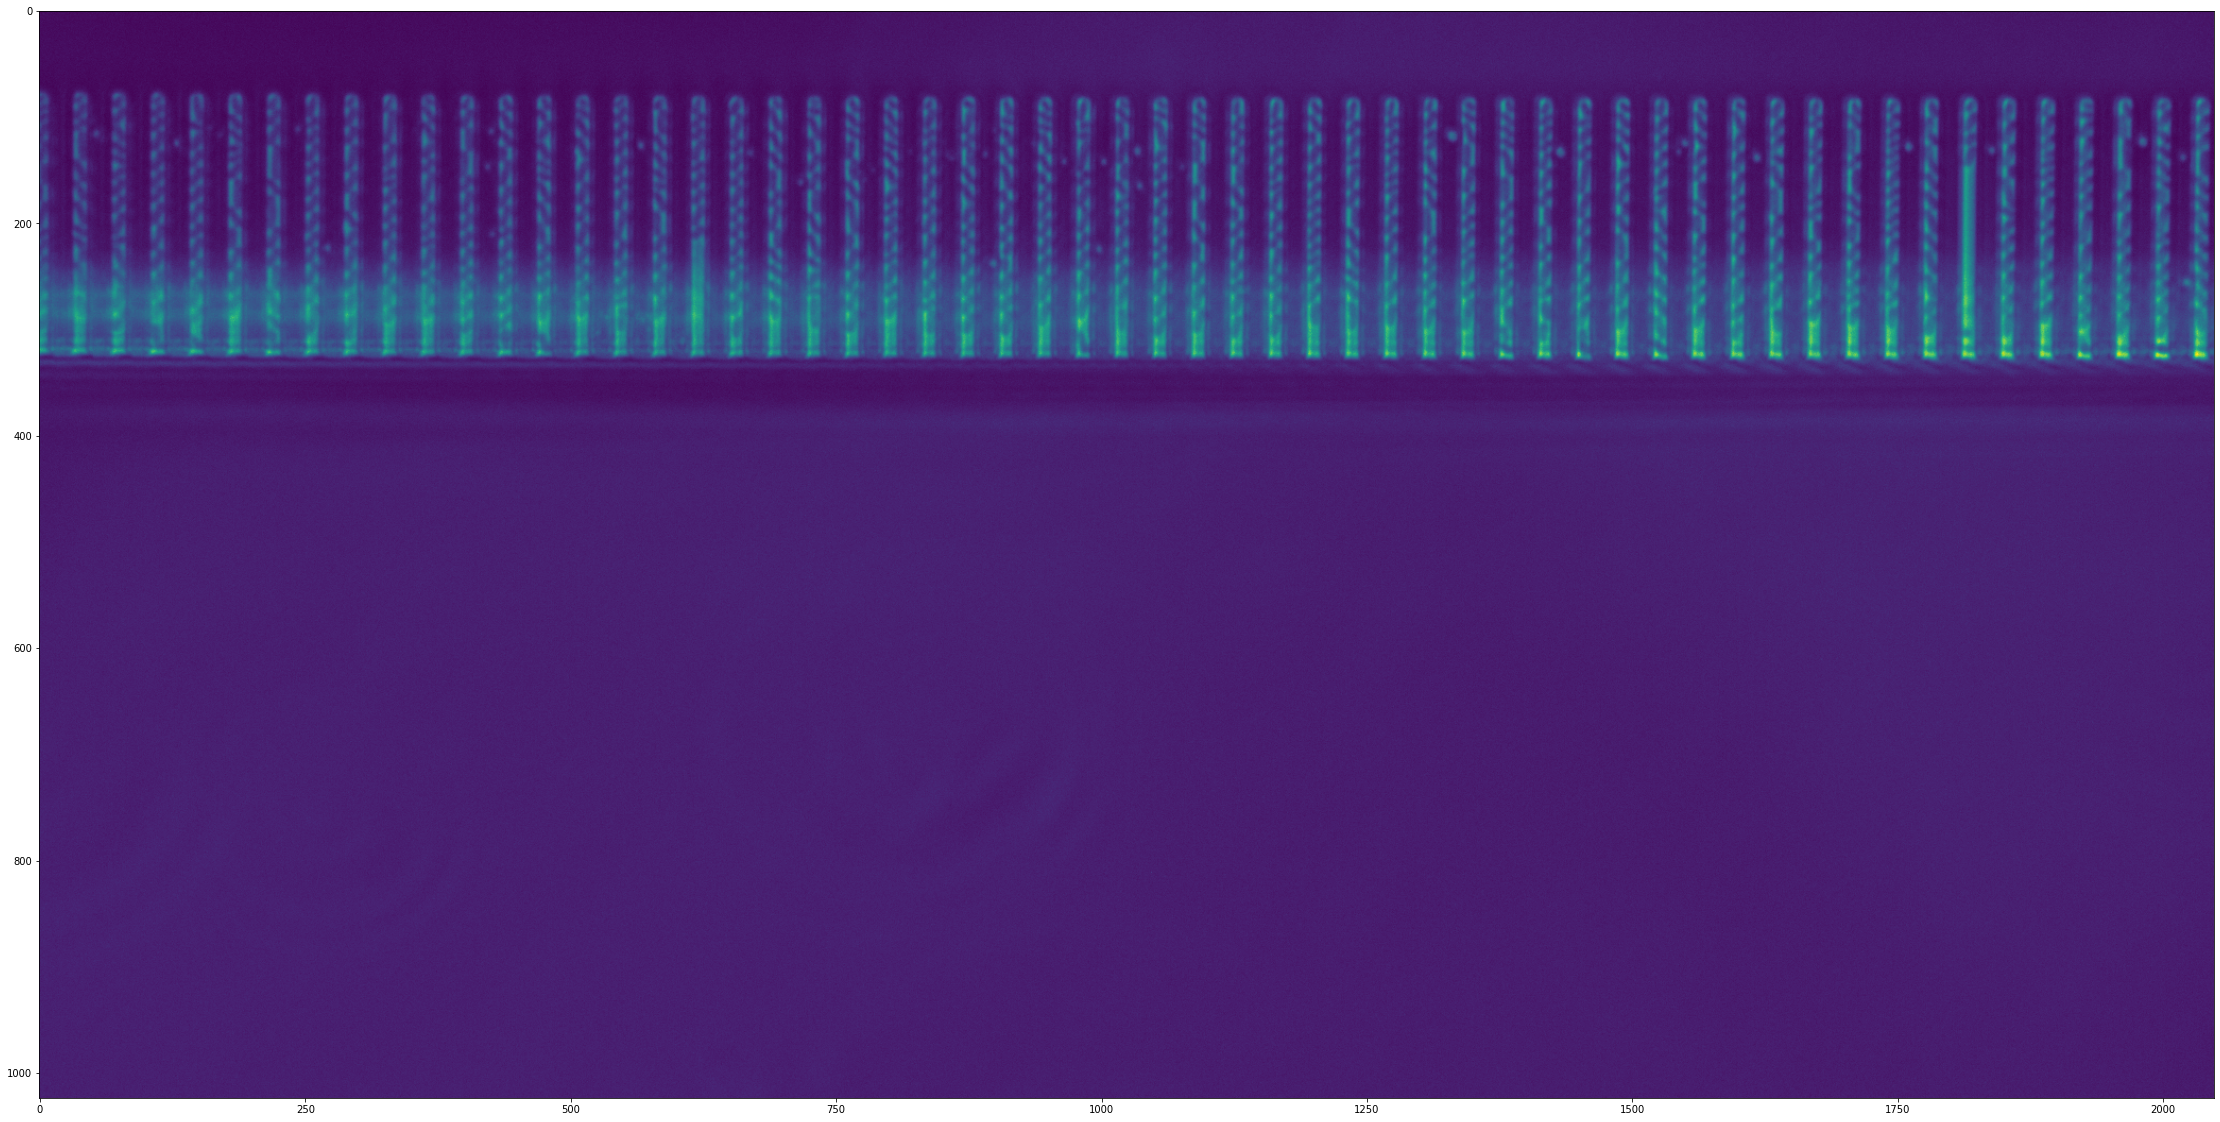

In [63]:
f, ax = plt.subplots(figsize=(40,20))
plt.imshow(top_half_images[0])

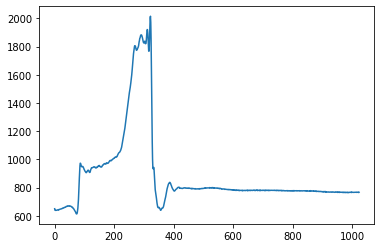

In [62]:
plt.plot(np.mean(top_half_images[0],axis=1))

In [106]:
from skimage.filters import try_all_threshold
from skimage.filters import threshold_minimum, threshold_li

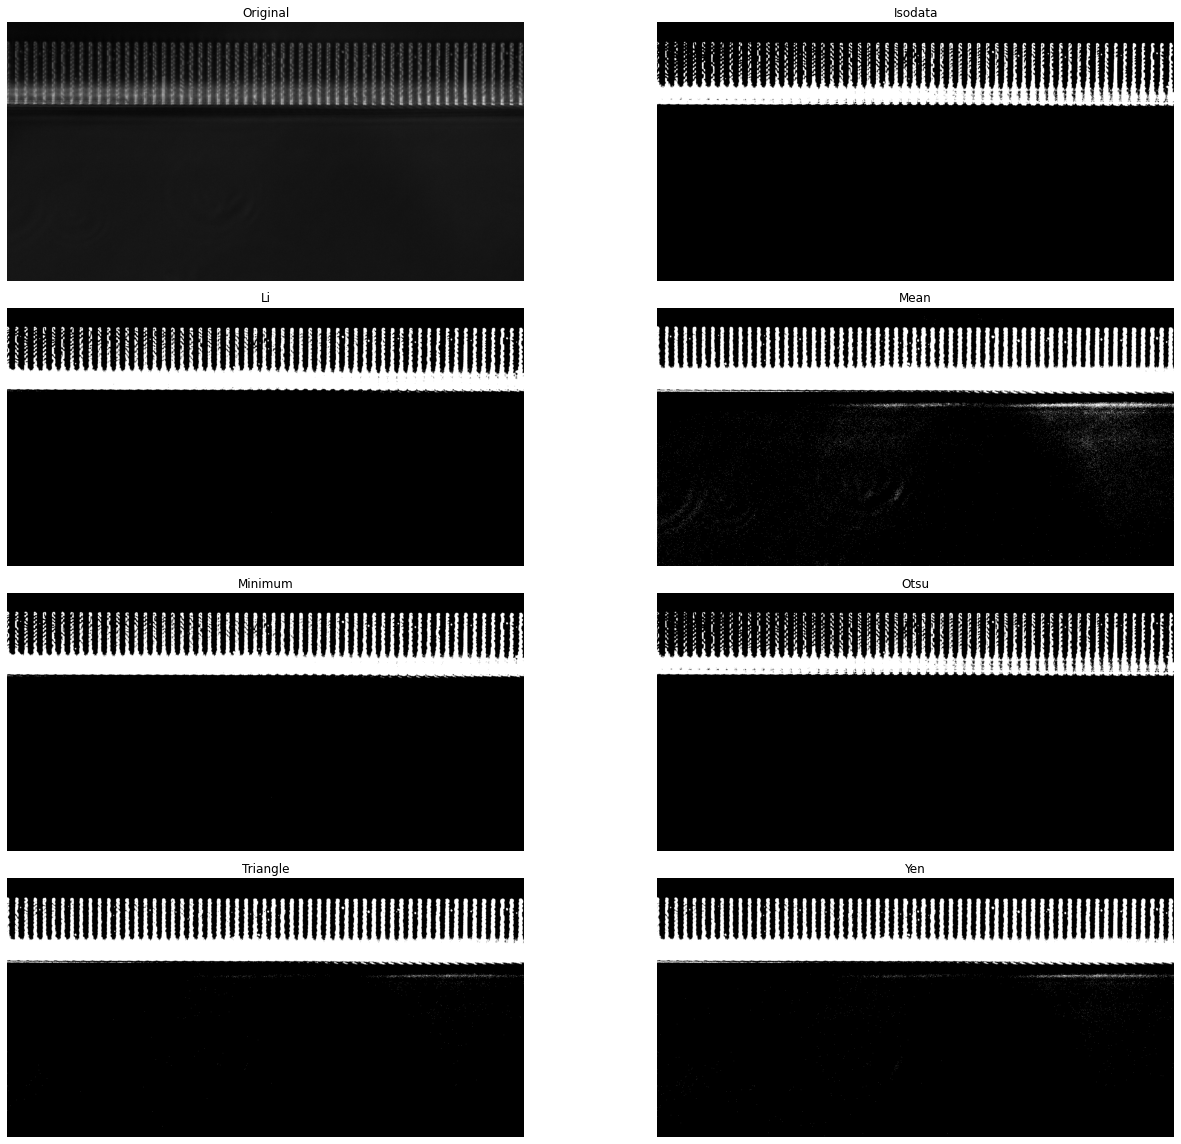

In [93]:
fig, ax = try_all_threshold(top_half_images[0], figsize=(20, 16), verbose=False)


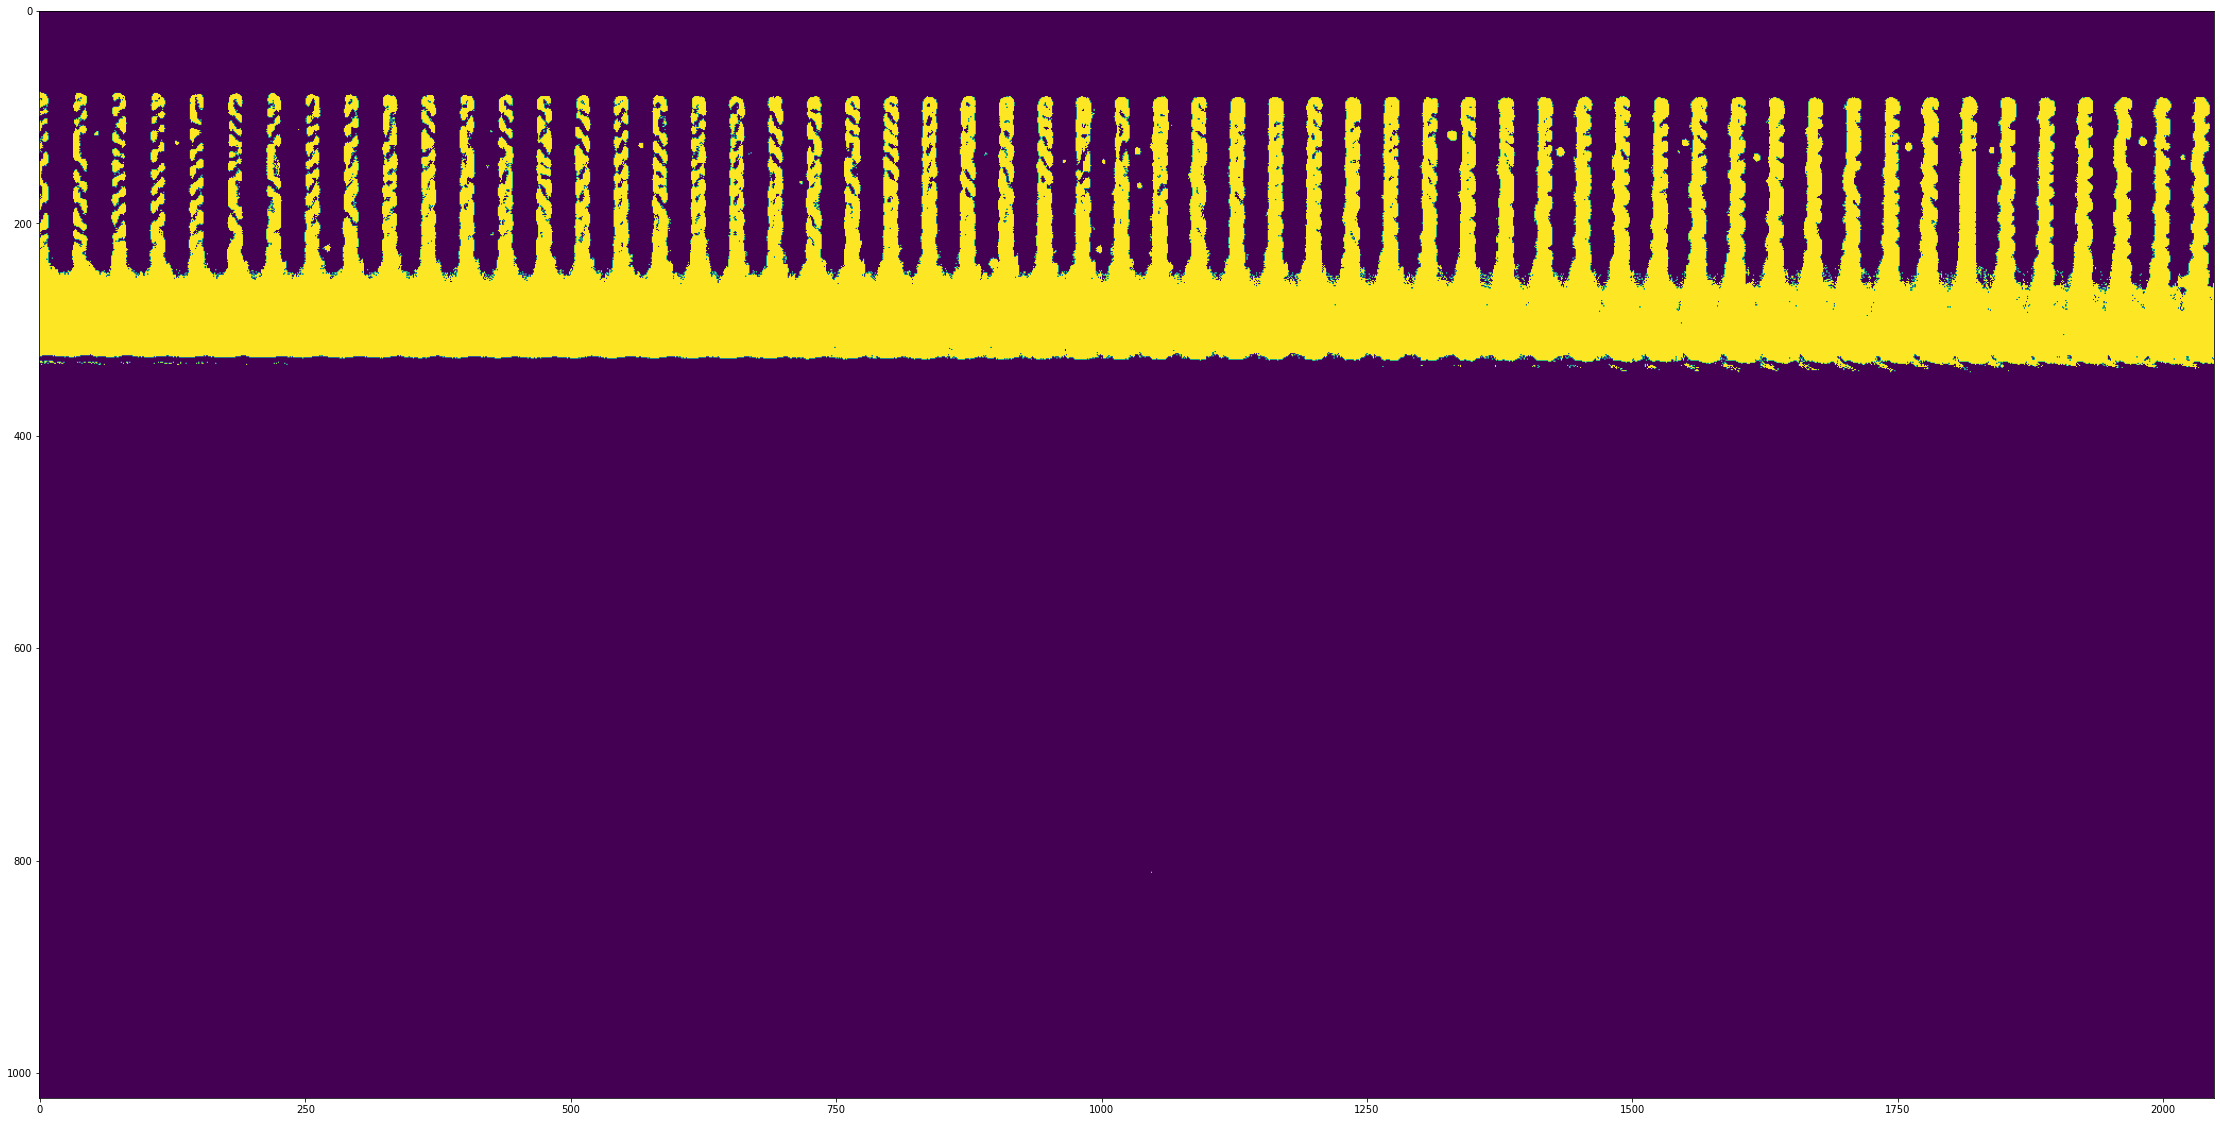

In [113]:
f, ax = plt.subplots(figsize=(40,20))
bin_image = top_half_images[0] > threshold_minimum(top_half_images[0]) * 1
plt.imshow(bin_image)

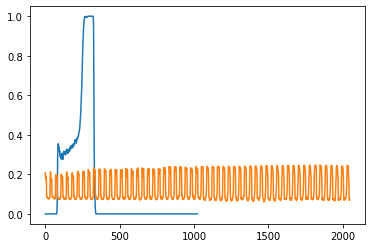

In [128]:
plt.plot(np.mean(bin_image, axis=1))
plt.plot(np.mean(bin_image, axis=0))

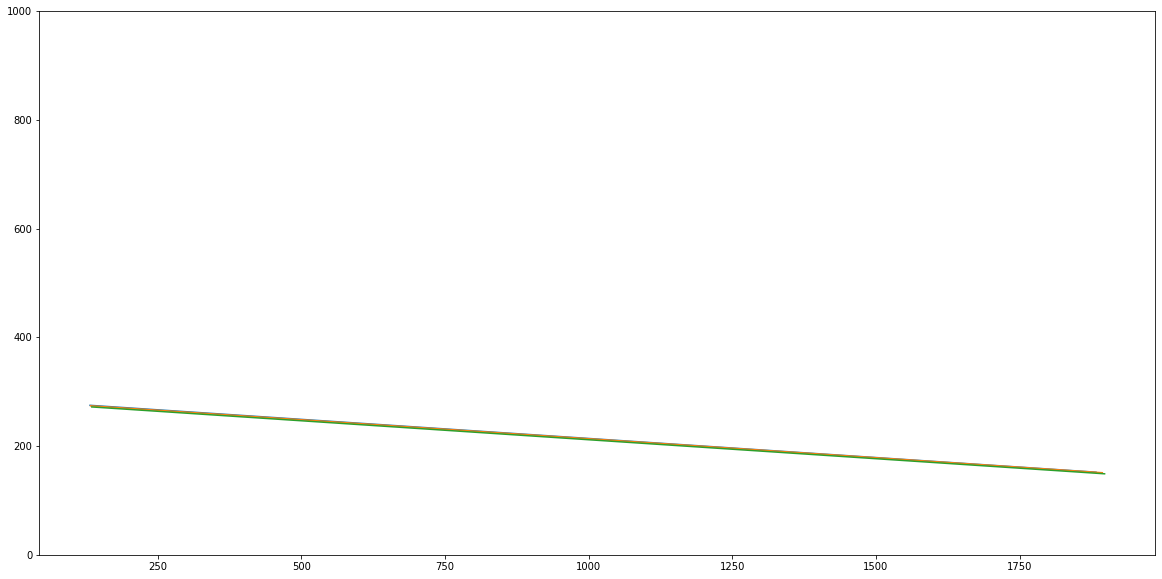

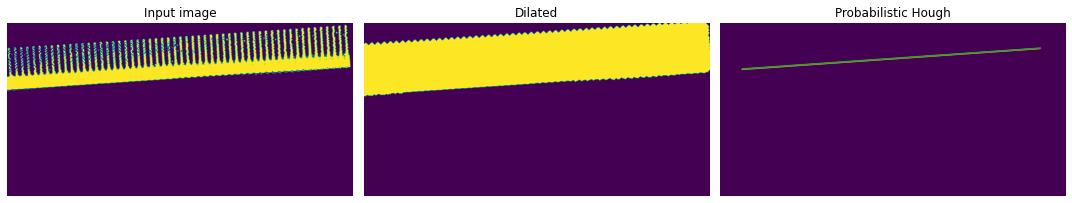

In [501]:
lines = probabilistic_hough_line(skeleton, threshold=155, line_length=int(0.6*skeleton.shape[1]),
                                 line_gap=10**10)
f, ax = plt.subplots(figsize=(20,10))
plt.ylim(0,1000)
for line in lines:
    p0, p1 = line
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]))
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(bin_rotated)
ax[0].set_title('Input image')

ax[1].imshow(labeled)
ax[1].set_title('Dilated')

ax[2].imshow(edges * 0)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, bin_rotated.shape[1]))
ax[2].set_ylim((bin_rotated.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

(0.0, 2048.0)

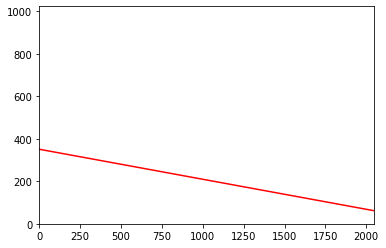

In [539]:
h, theta, d = hough_line(skeleton)
origin = np.array((0, skeleton.shape[1]))
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    plt.plot(origin, (y0, y1), '-r')
plt.ylim(0,skeleton.shape[0])
plt.xlim(0,skeleton.shape[1])

In [556]:
import math 
gradient = (y1-y0) /origin[1]
math.degrees(np.arctan(gradient))


-5.027932960893875

-0.08775398473714542

In [489]:
def get_gradient(line):
    return (line[1][0] - line[1][1])/(line[0][0] - line[0][1])

get_gradient(lines[0])

-25.651515151515152

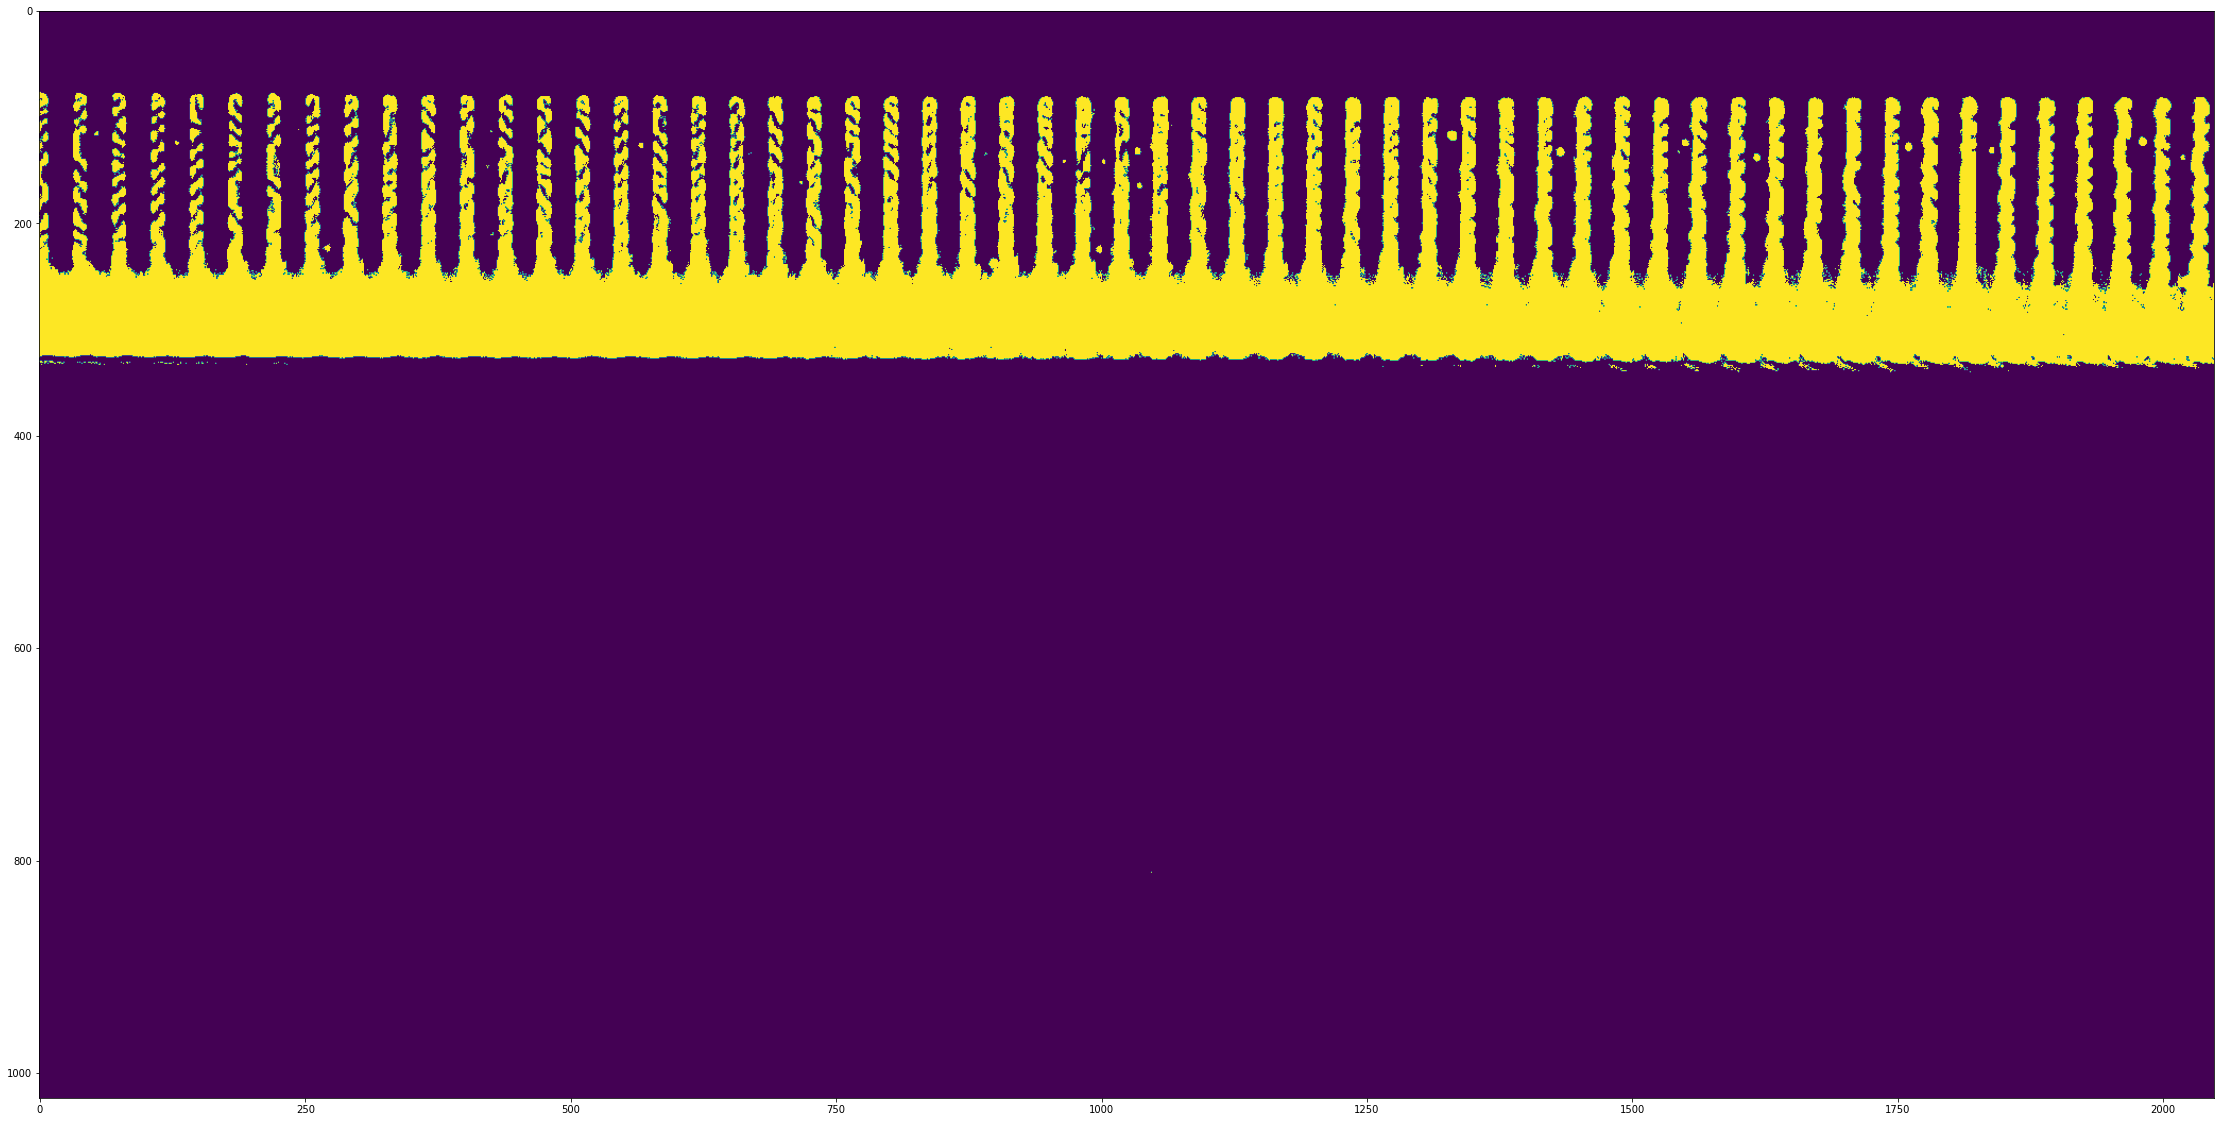

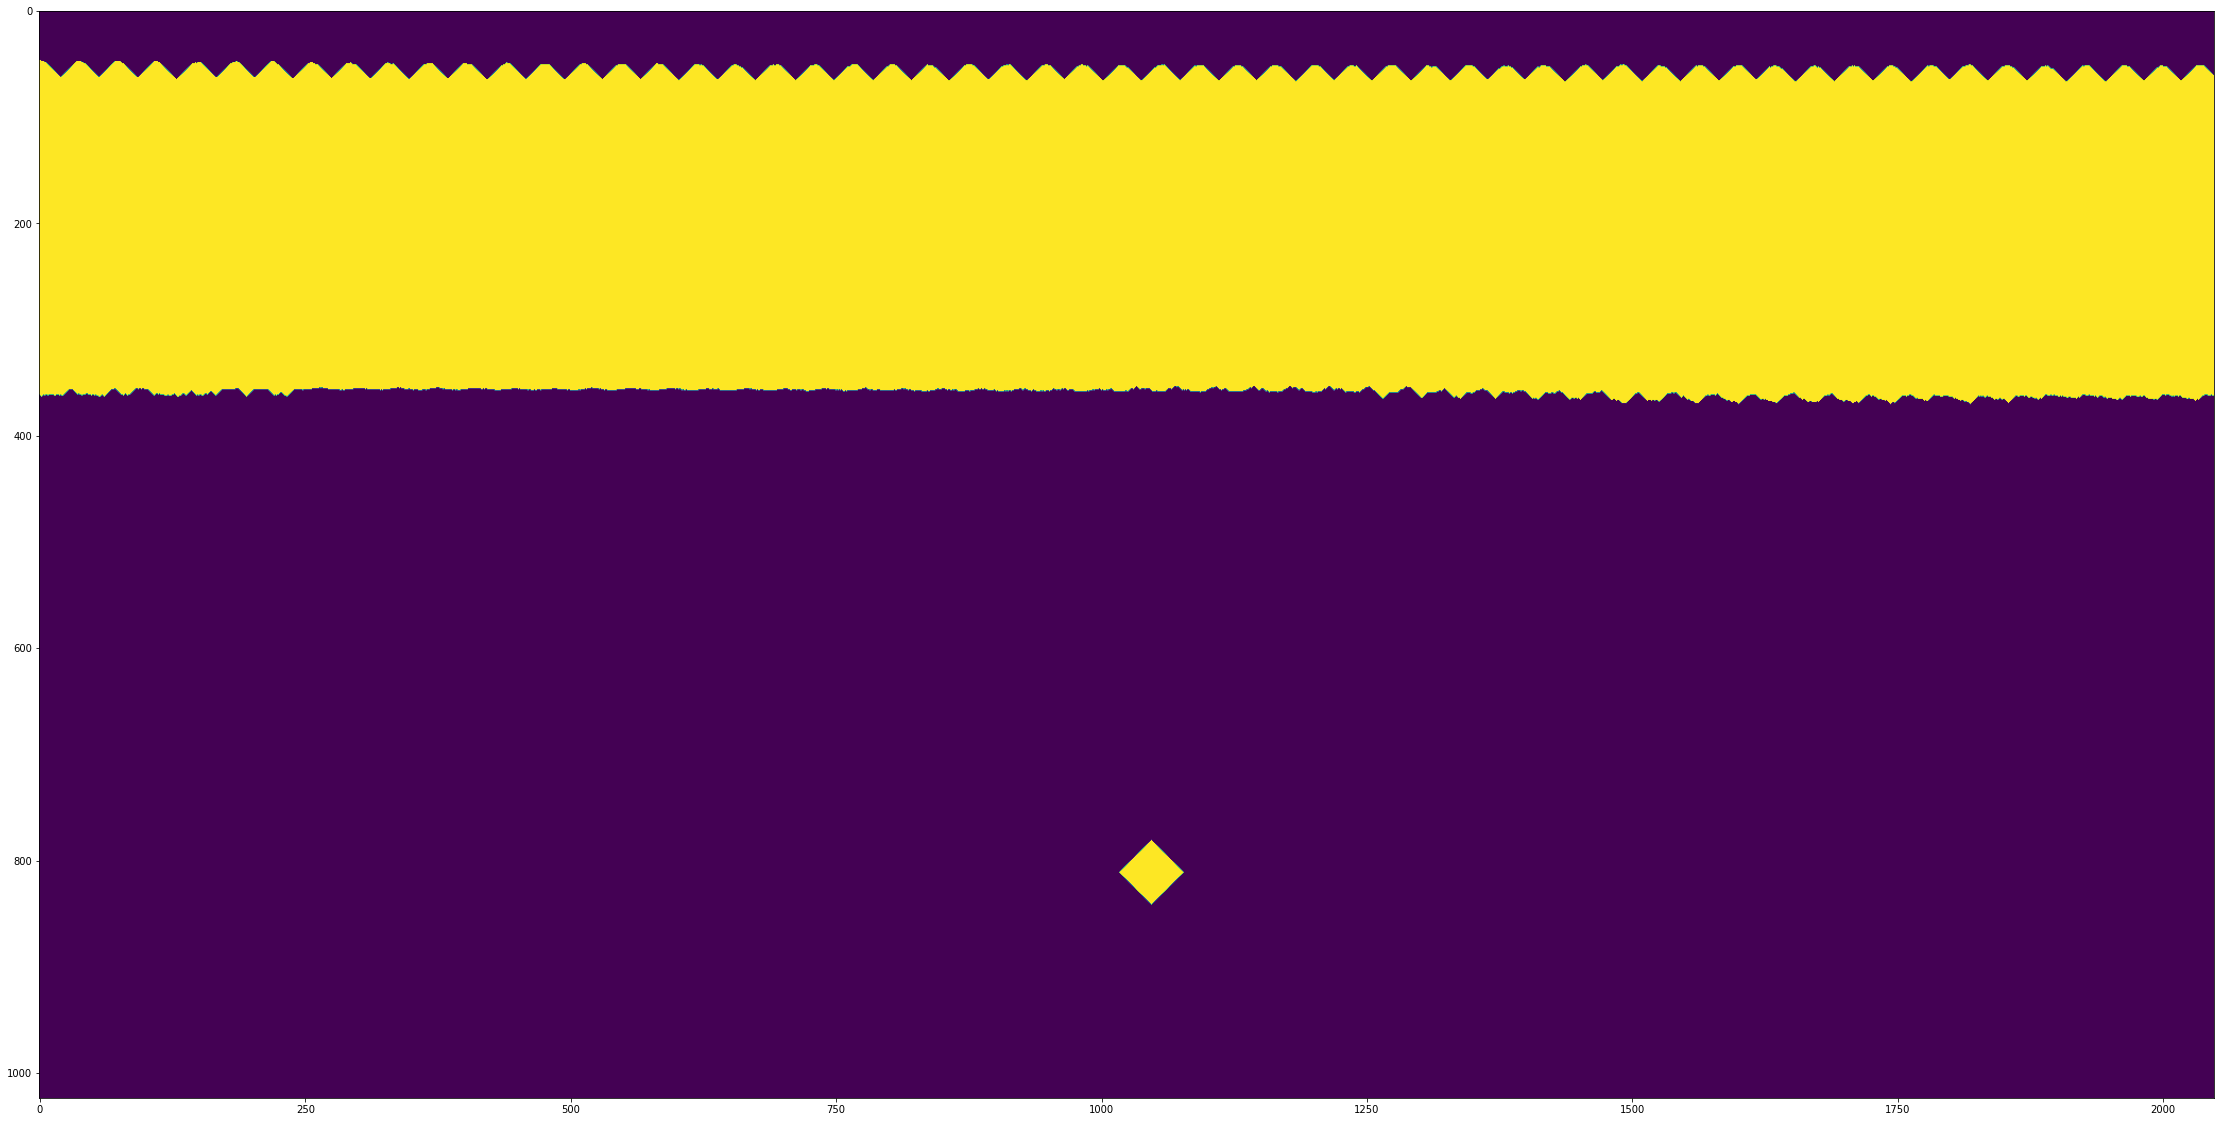

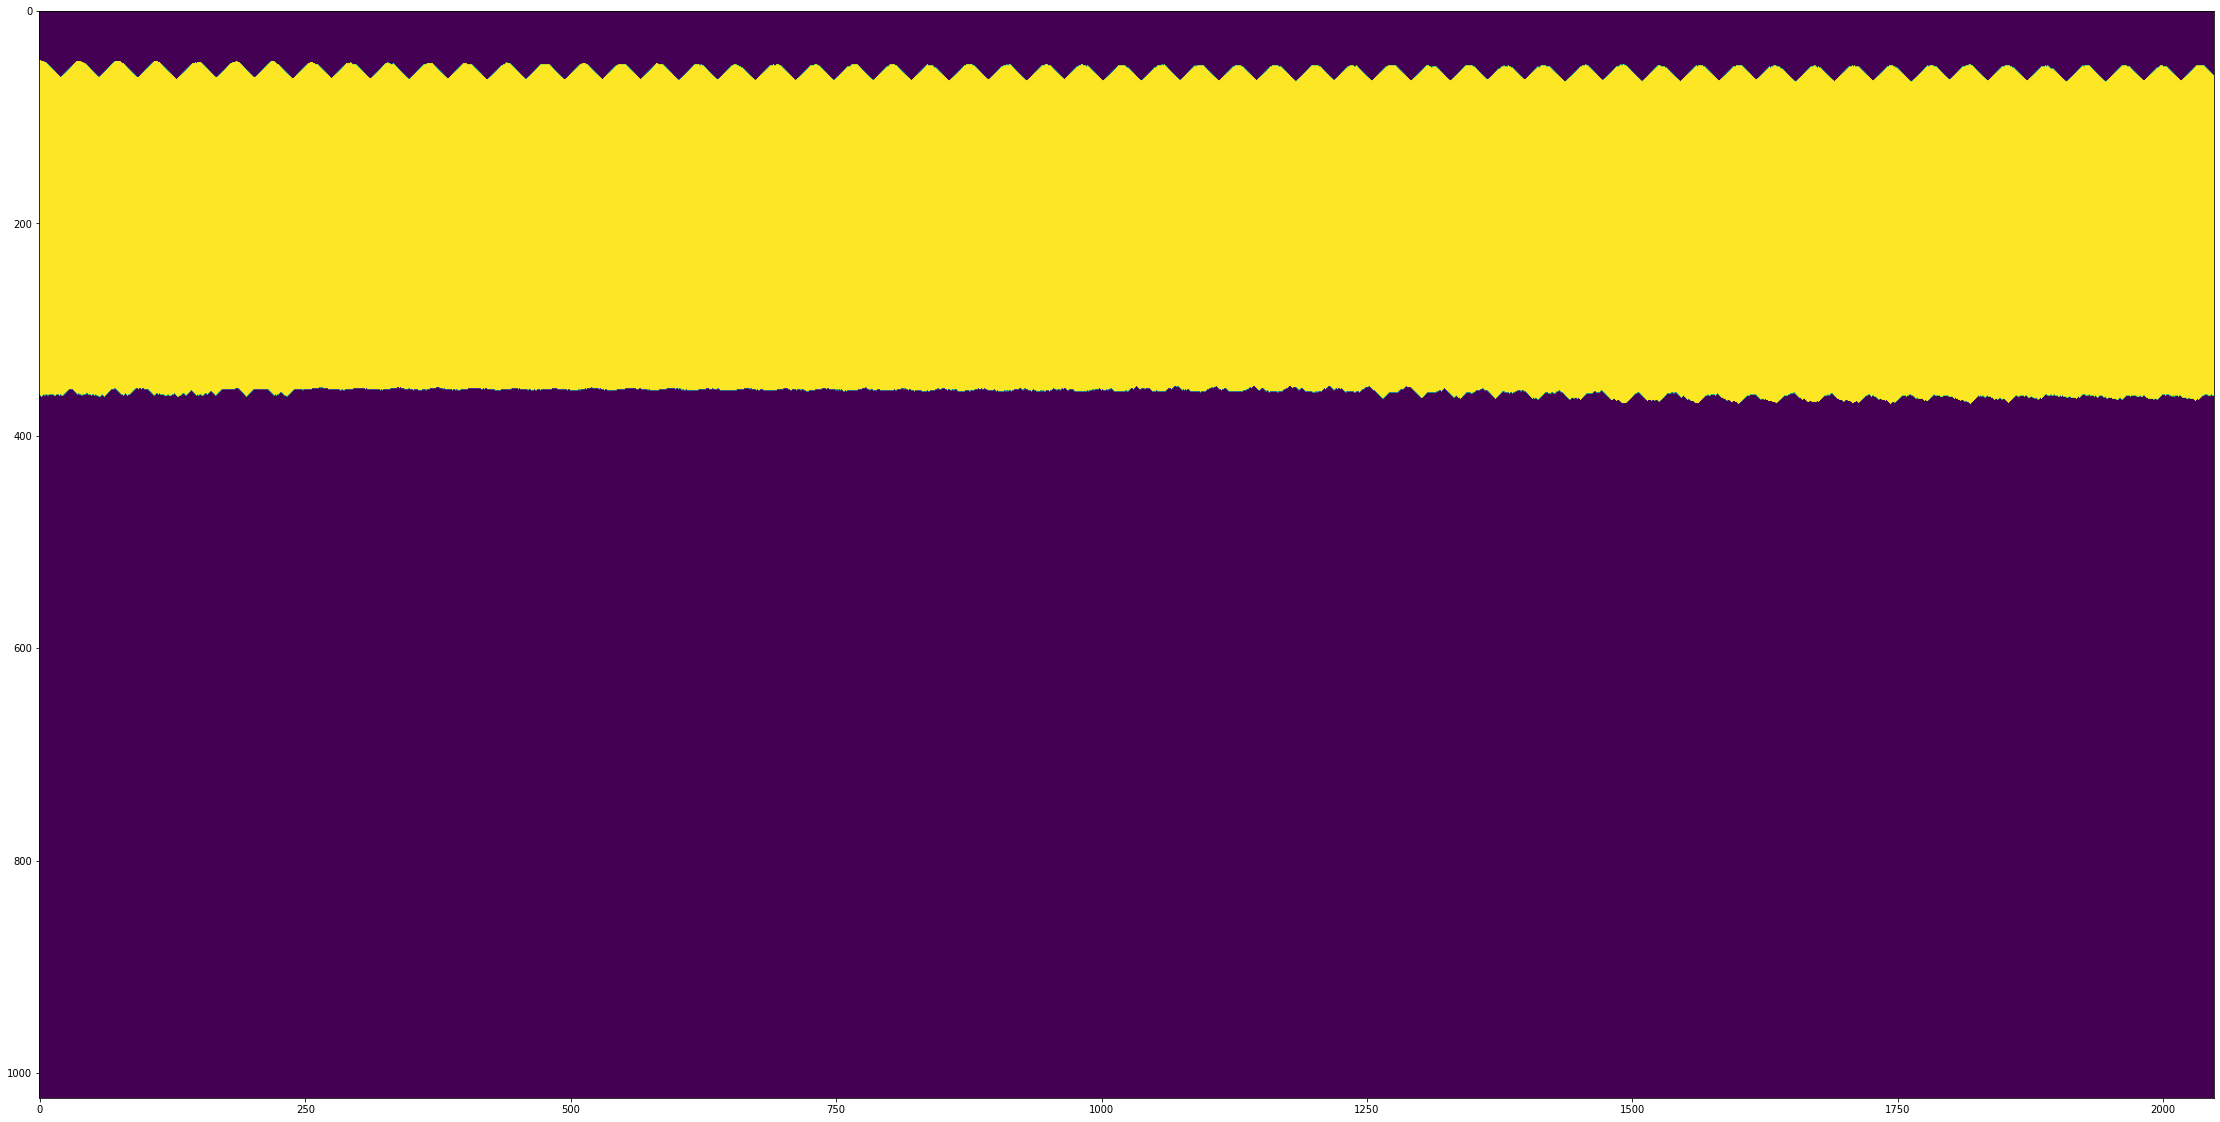

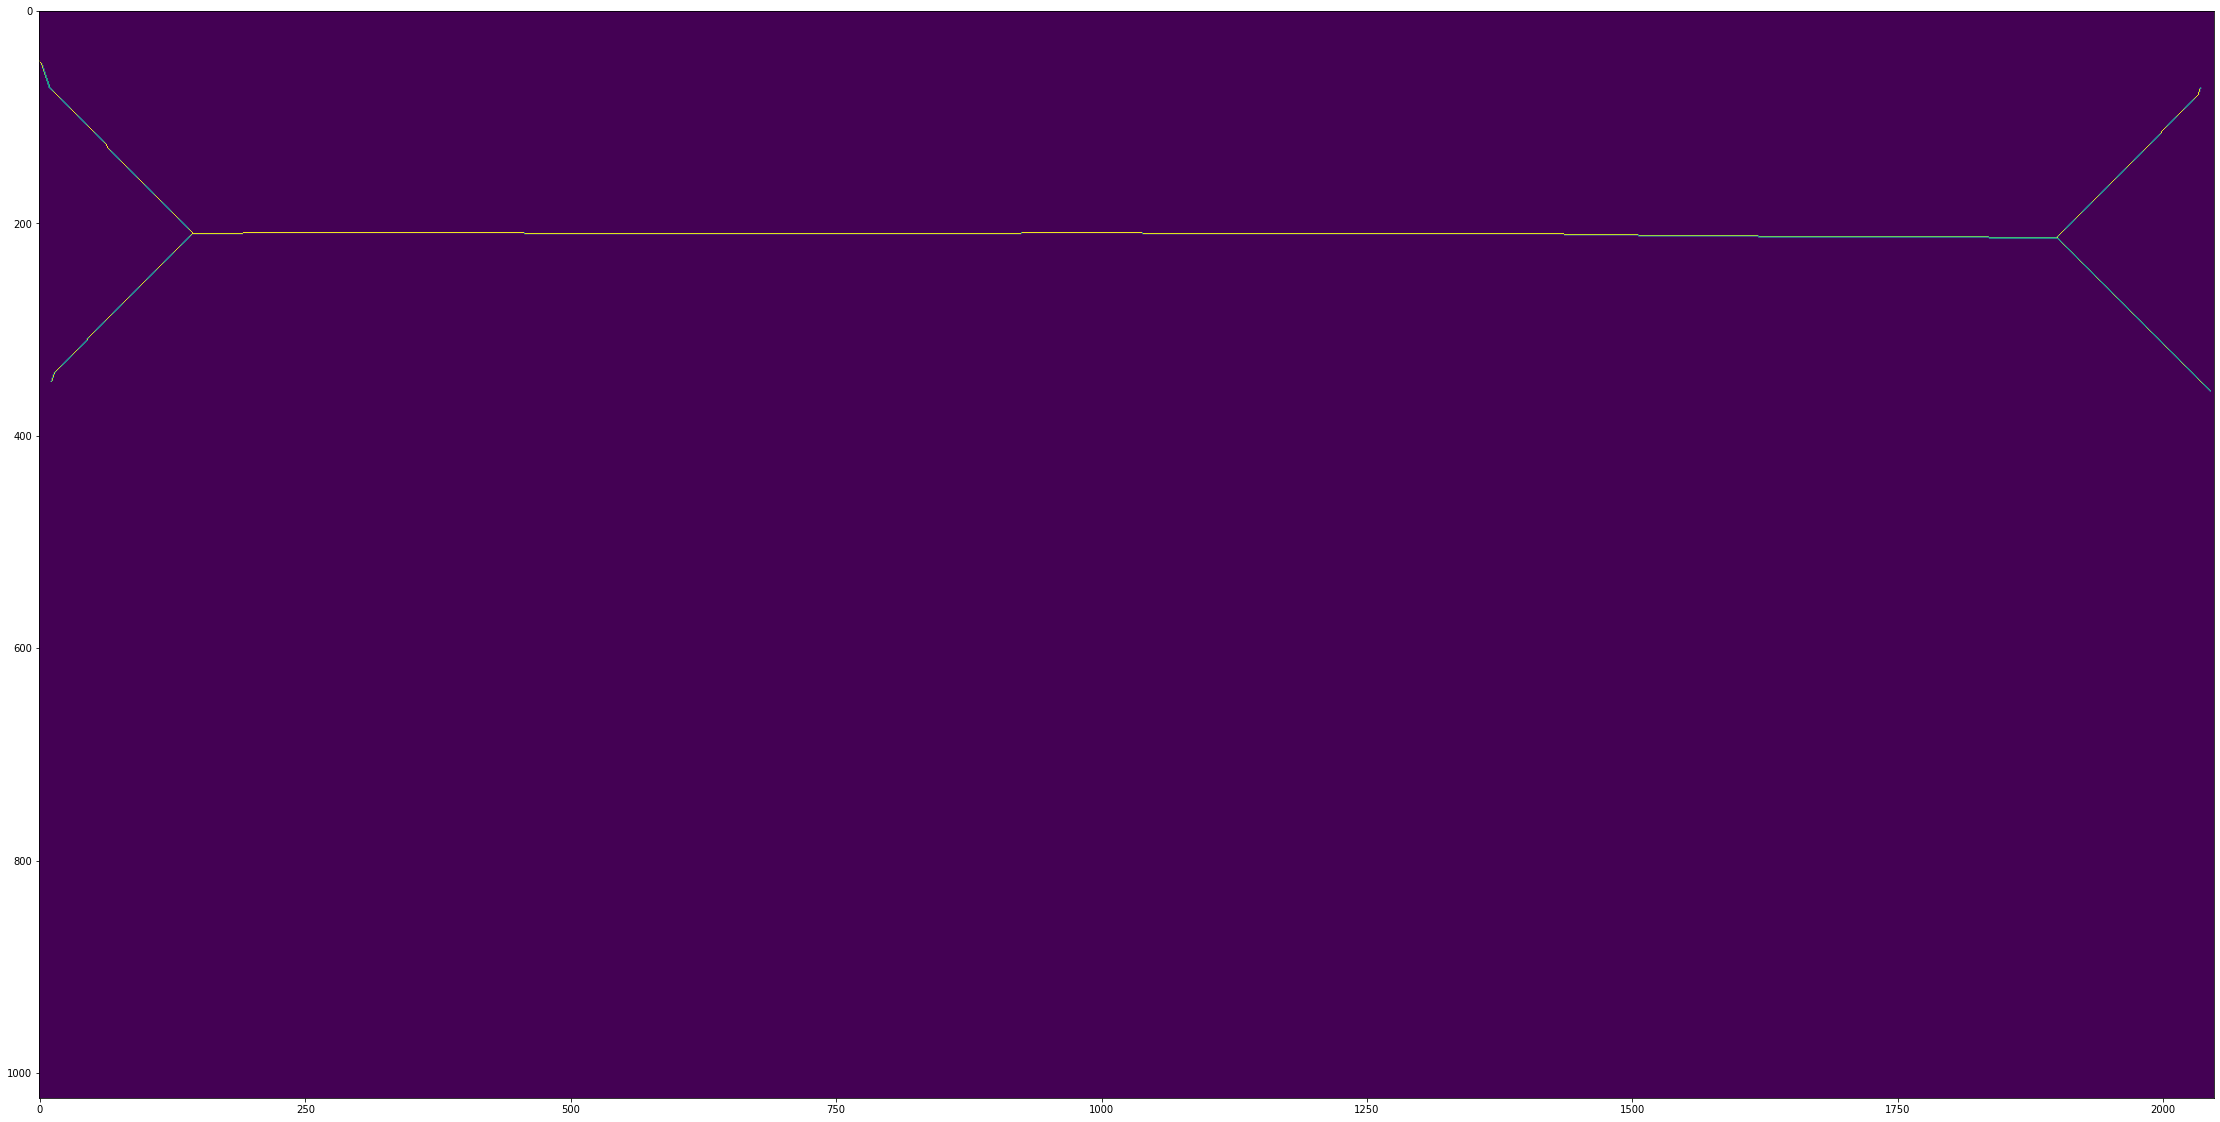

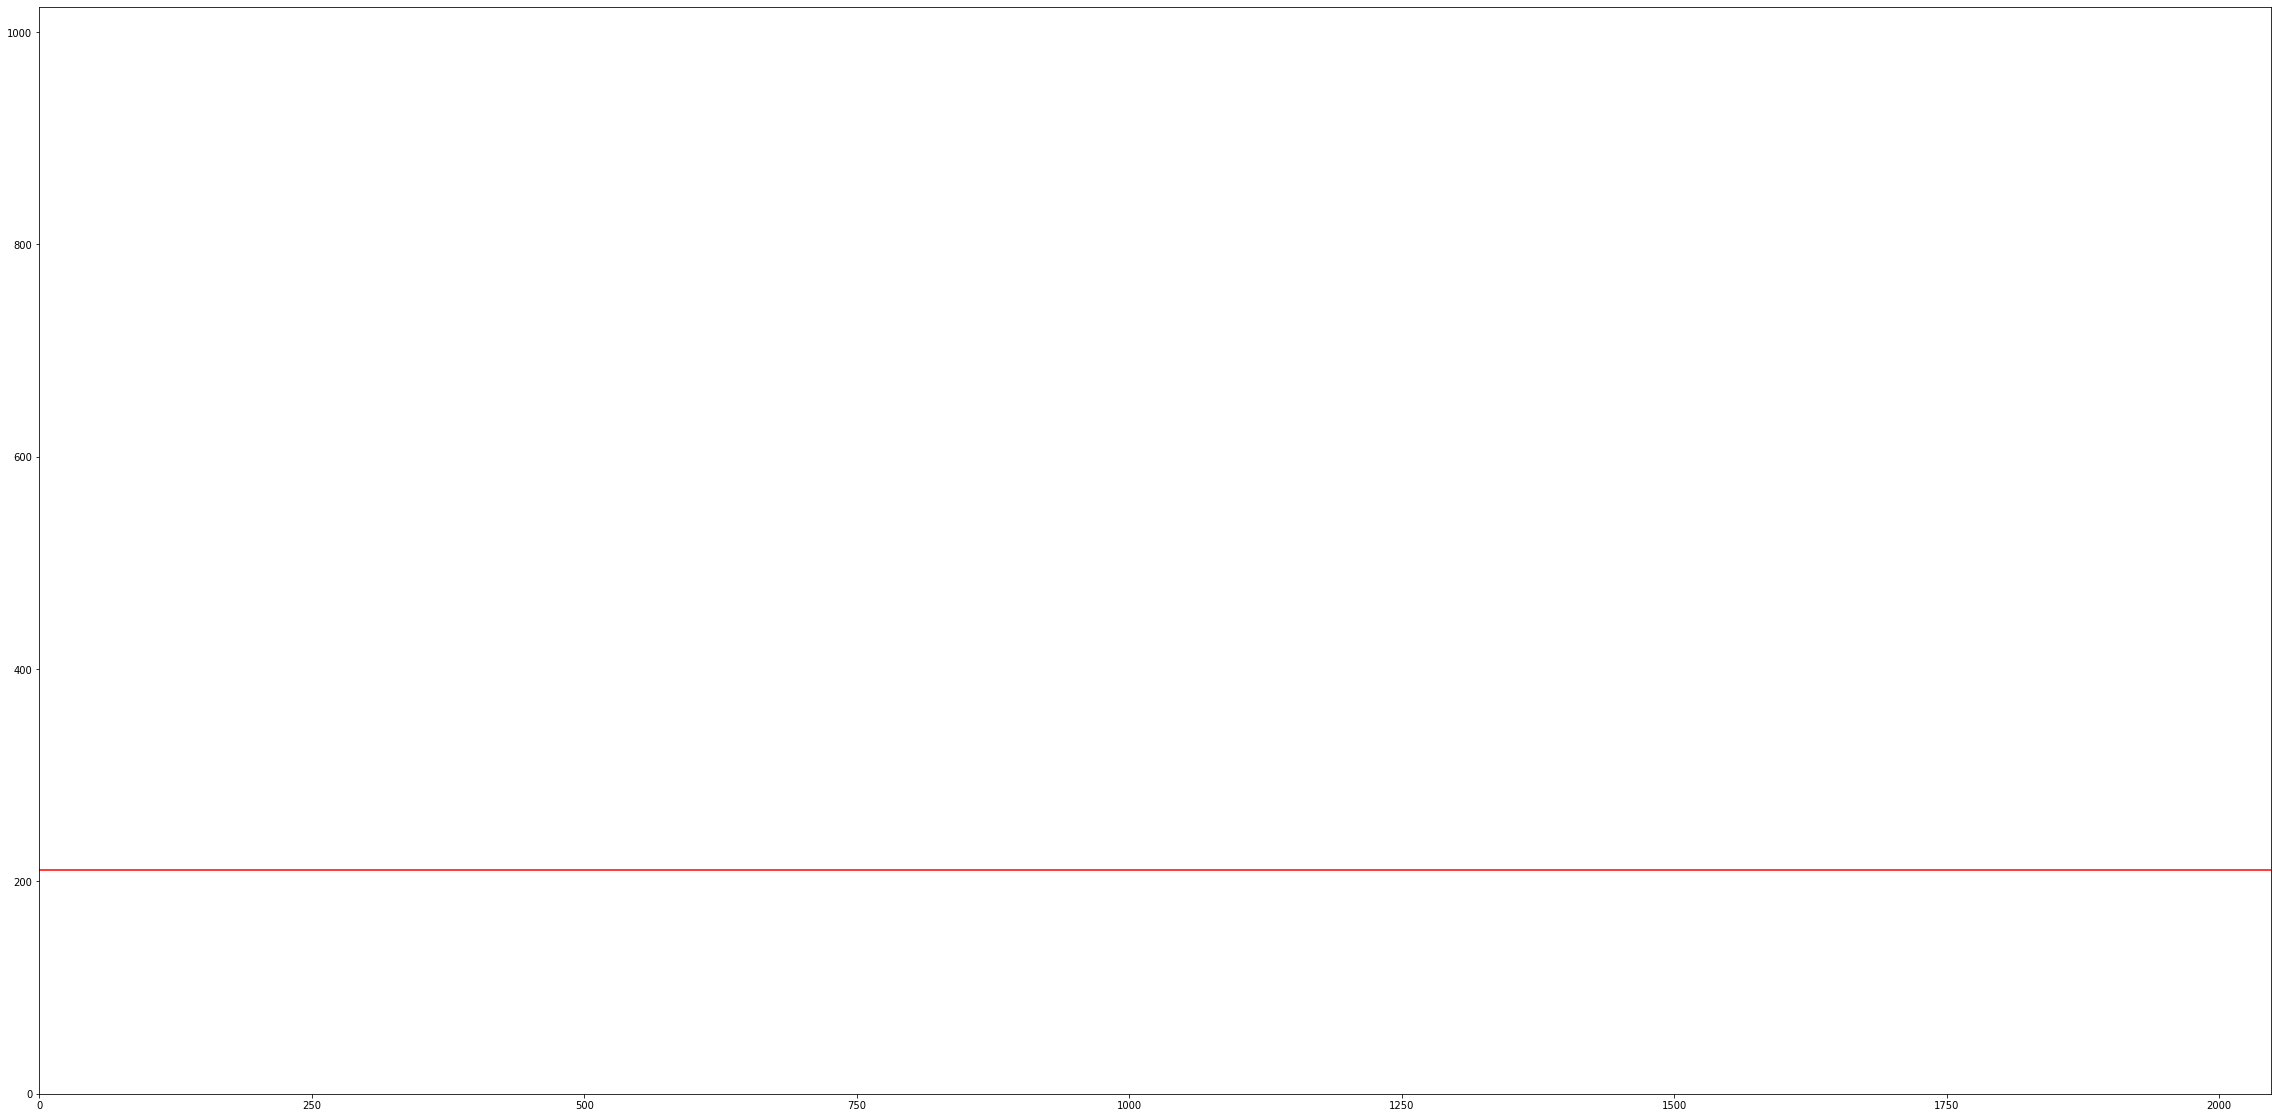

-3.1805546814635168e-15


In [558]:
f, ax = plt.subplots(figsize=(40,20))
bin_rotated = skimage.transform.rotate(image = bin_image, angle = 0)
plt.imshow(bin_rotated)
plt.show()



f, ax = plt.subplots(figsize=(40,20))
from skimage.morphology import binary_dilation
dilated = scipy.ndimage.morphology.binary_dilation(bin_rotated, iterations = 30)
plt.imshow(dilated)



f, ax = plt.subplots(figsize=(40,20))
labeled, num_regions  = mh.label(dilated)
sizes = mh.labeled.labeled_size(labeled)
mh.labeled.labeled_size(labeled)
too_small = np.where(sizes < sizes[1]-1)
labeled = mh.labeled.remove_regions(labeled, too_small)
plt.imshow(labeled)
plt.show()


f, ax = plt.subplots(figsize=(40,20))
skeleton = skeletonize(labeled)
plt.imshow(skeleton)
plt.show()

f, ax = plt.subplots(figsize=(40,20))

h, theta, d = hough_line(skeleton)
origin = np.array((0, skeleton.shape[1]))
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    plt.plot(origin, (y0, y1), '-r')
plt.ylim(0,skeleton.shape[0])
plt.xlim(0,skeleton.shape[1])
plt.show()


gradient = (y1-y0) /origin[1]
print(math.degrees(np.arctan(gradient)))



In [523]:
np.max(labeled)

1

In [526]:
bin_rotated

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [484]:
x_mean_intensity = np.mean(bin_rotated, axis=0)
y_mean_intensity = np.mean(bin_rotated, axis=1)
indexes = peakutils.indexes(x_mean_intensity, thres=0.0/max(x_mean_intensity), min_dist=30)


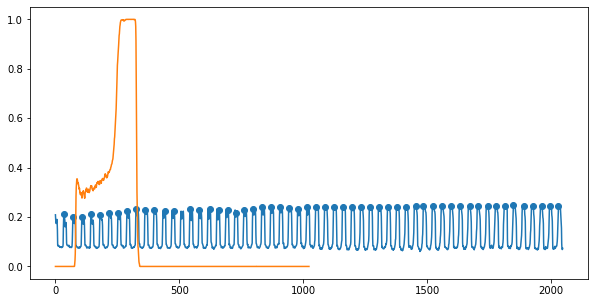

In [485]:
f, ax = plt.subplots(figsize=(10,5))
plt.plot(x_mean_intensity)
plt.plot(y_mean_intensity)
plt.scatter(indexes, x_mean_intensity[indexes])

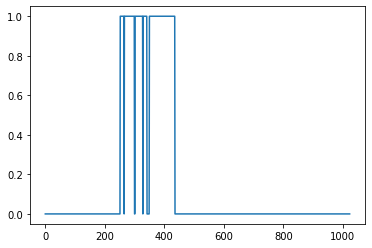

In [184]:
plt.plot(bin_rotated[:,indexes[9]])

In [204]:
N = 16
d = int(bin_rotated.shape[1]/N)

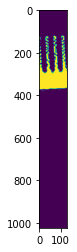

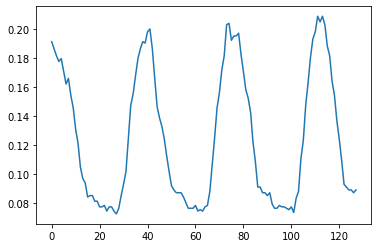

In [223]:
plt.imshow(bin_rotated[:,d:d*2])
plt.show()
plt.plot(np.mean(bin_rotated[:,d:d*2],axis=0))
plt.show()

In [209]:
d

128